In [63]:
# 1. Introduction
# Customer Behavior Analysis for Online Retail Data

"""
This EDA investigates customer purchase behavior using transactional data from a UK-based online retail store.
We aim to understand key patterns in buying behavior, high-value products, country-wise revenue, and segment customers using RFM analysis.
"""

'\nThis EDA investigates customer purchase behavior using transactional data from a UK-based online retail store.\nWe aim to understand key patterns in buying behavior, high-value products, country-wise revenue, and segment customers using RFM analysis.\n'

In [64]:
# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime

In [65]:
# 3. Load Dataset
df = pd.read_excel('../data/Online Retail.xlsx', engine='openpyxl')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [66]:
# 4. Basic Info & Cleaning
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [67]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [68]:
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

In [69]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [70]:
# Filter out negative quantities and values
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [71]:
# 5. Feature Engineering
# Create TotalPurchase column
df['TotalPurchase'] = df['Quantity'] * df['UnitPrice']

In [72]:
# Convert InvoiceDate to datetime (if not already)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [73]:
# Extract year, month, day, weekday, hour
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

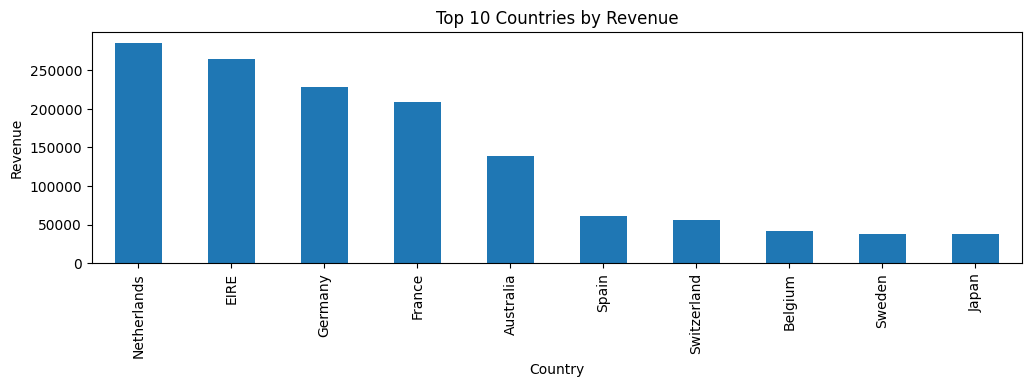

In [74]:
#  6. Visualizations
# Revenue by country
revenue_country = df.groupby('Country')['TotalPurchase'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 3))
revenue_country[1:11].plot(kind='bar')  # Skipping 'United Kingdom' if it's overwhelmingly large
plt.title('Top 10 Countries by Revenue')
plt.ylabel('Revenue')
plt.xlabel('Country')
plt.show()

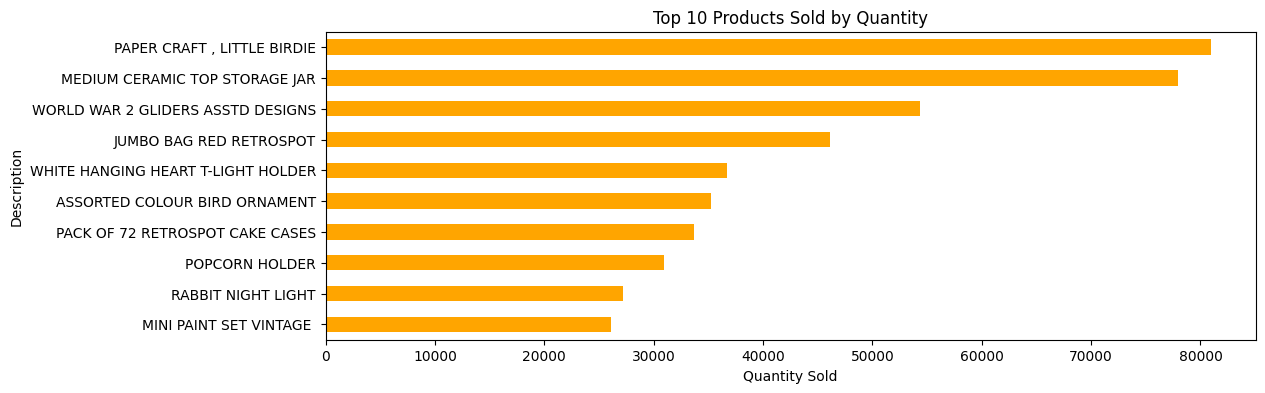

In [75]:
# Top 10 best-selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 4))
top_products.plot(kind='barh', color='orange')
plt.title('Top 10 Products Sold by Quantity')
plt.xlabel('Quantity Sold')
plt.gca().invert_yaxis()
plt.show()

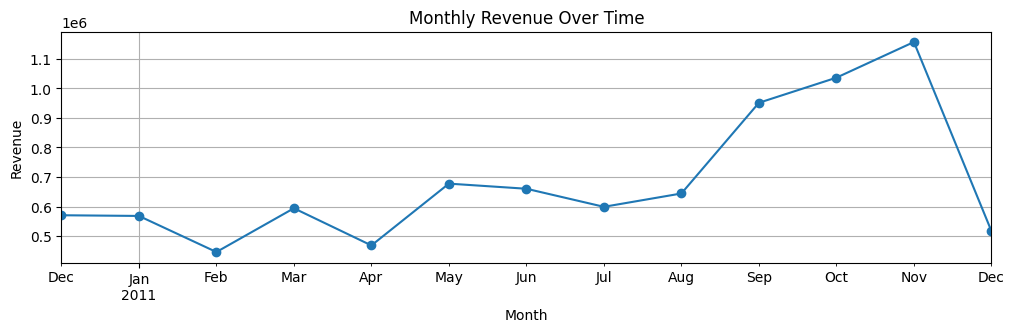

In [76]:

# Purchase patterns over time
monthly_revenue = df.groupby('InvoiceMonth')['TotalPurchase'].sum()
monthly_revenue.plot(kind='line', figsize=(12, 3), marker='o')
plt.title('Monthly Revenue Over Time')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.grid()
plt.show()

In [77]:
#  7. RFM Analysis
# Snapshot date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPurchase': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [78]:
# Score each metric
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

In [79]:
# Combine into RFM segment
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R','F','M']].astype(int).sum(axis=1)

In [80]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,7,4310.00,4,4,4,444,12
12348.0,75,4,1797.24,2,3,4,234,9
12349.0,19,1,1757.55,3,1,4,314,8
12350.0,310,1,334.40,1,1,2,112,4
